In [ ]:
%pip install velo-sdk seaborn matplotlib --quiet

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Relay Colab secret to os.environ to keep the core logic vendor free
try:
    import os
    from google.colab import auth, userdata
    auth.authenticate_user()

    os.environ["RISKTHINKING_API_KEY"] = userdata.get("RISKTHINKING_API_KEY")
except Exception:
    # likely not in Google Colab, ignore and move on
    pass

In [3]:
# Time horizons to compare
HORIZONS = [2030, 2050, 2070, 2090]

# Stochastic View by Riskthinking.AI
PATHWAY = "SV"

In [4]:
from velo_sdk.api import APIClient
import polars as pl

client = APIClient()  # VELO SDK auto detects $RISKTHINKING_API_KEY env var

# Search for the company to look at
results = client.companies.search_companies(name="Microsoft")
company_id = results[0].id

In [5]:
# Create a dataframe of uninsurable assets
dataframes = []
for horizon in HORIZONS:
    results = client.companies.list_uninsurable_company_assets(company_id, PATHWAY, horizon)
    dataframes.append(pl.DataFrame(results).with_columns(pl.lit(horizon).alias("horizon")))

# Combine all results into a single dataframe
combined_df = pl.concat(dataframes)

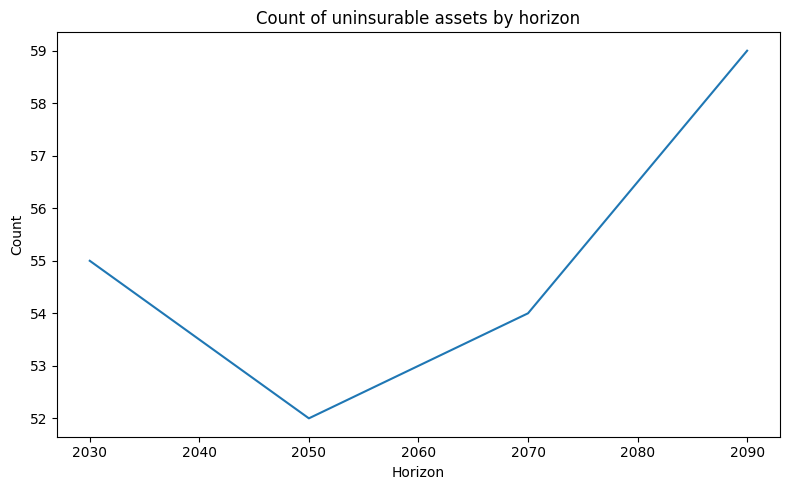

In [6]:
# Show the count of uninsurable assets by horizon
horizon_df = combined_df.group_by("horizon").agg(count=pl.len())
fig, ax = plt.subplots(figsize=(8, 5)) 
sns.lineplot(x="horizon", y="count", data=horizon_df, ax=ax)
ax.set_title("Count of uninsurable assets by horizon")
ax.set_xlabel("Horizon")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

In [7]:
# Identify the top 10 uninsurable assets for 2030
combined_df.filter(pl.col("horizon") == 2030).sort(by="var_95", descending=True).head(
    10
).select(["asset_id", "asset_type", "country", "state", "city", "var_95"])

asset_id,asset_type,country,state,city,var_95
str,str,str,str,str,f64
"""99322d12-1af2-411b-9ee4-fb95b6…","""Management of Companies and En…","""BRA""","""State of Bahia""","""Salvador""",0.7339
"""613e5677-1a90-4b96-8176-d48e59…","""Management of Companies and En…","""USA""","""Texas""","""Burkburnett""",0.711566
"""5471ff69-a252-4c15-8b34-ec209e…","""Management of Companies and En…","""USA""","""New Mexico""","""Rio Rancho""",0.705621
"""f295eb52-805d-4872-9bc8-71687e…","""Management of Companies and En…","""MEX""","""Nayarit""","""San Pancho""",0.691573
"""f6d48365-9fe3-4066-89bc-d16cc9…","""Management of Companies and En…","""PAK""","""Hyderabad, Sindh""","""Hyderabad""",0.683559
"""161ce99c-7b01-4533-8321-e0b787…","""Management of Companies and En…","""CHN""","""Shanghai Municipality""","""Xuhui District""",0.680574
"""08ab3dba-3ef0-42e8-884c-c4aba3…","""Management of Companies and En…","""IND""","""Maharashtra""","""Pune""",0.662898
"""6db77369-6df1-4cc8-9cc1-4a4eea…","""Computing Infrastructure, Data…","""IND""","""Mahārāshtra""","""Pune""",0.662898
"""e6c60abd-2a78-418d-ac38-ac842e…","""Religious, Grantmaking, Civic,…","""BRA""","""State of Minas Gerais""","""Pouso Alegre""",0.657037


In [8]:
# Create a dataframe of stranded assets
dataframes = []

for horizon in HORIZONS:
    results = client.companies.list_stranded_company_assets(company_id, PATHWAY, horizon)
    df = pl.DataFrame(results) # Convert to polars dataframe
    df = df.with_columns(pl.lit(horizon).alias("horizon")) # Add horizon column
    dataframes.append(df)

# Combine all results into a single dataframe
combined_df = pl.concat(dataframes)

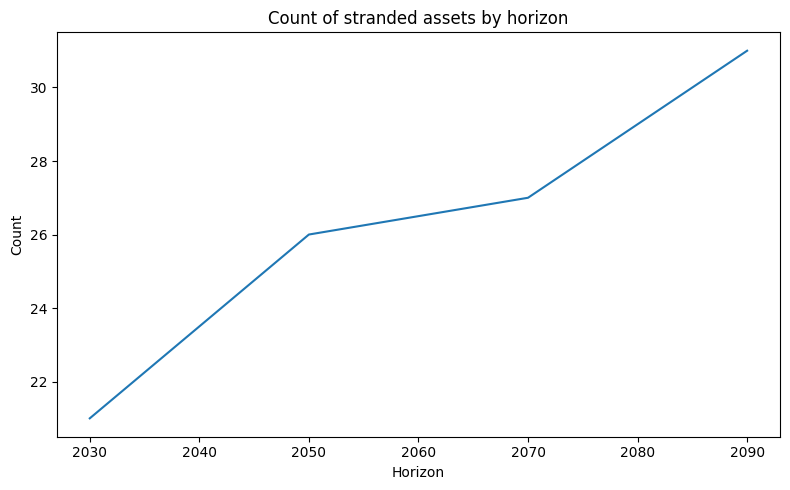

In [9]:
# Show the count of stranded assets by horizon
horizon_df = combined_df.group_by("horizon").agg(count=pl.len())
fig, ax = plt.subplots(figsize=(8, 5)) 
sns.lineplot(x="horizon", y="count", data=horizon_df, ax=ax)
ax.set_title("Count of stranded assets by horizon")
ax.set_xlabel("Horizon")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

In [10]:
# Identify the top 10 stranded assets for 2030
combined_df.filter(pl.col("horizon") == 2030).sort(by="var_95", descending=True).head(
    10
).select(["asset_id", "asset_type", "country", "state", "city", "var_95"])

asset_id,asset_type,country,state,city,var_95
str,str,str,str,str,f64
"""3d2a0e45-2592-4f35-b507-45c45e…","""Professional Services""","""BGD""","""Barisal""","""Barisal""",1.684691
"""29d8edd5-3279-4bee-b26e-5e9868…","""Professional Services""","""IDN""","""East Java""","""Sidoarjo Regency""",1.159572
"""f1434f6a-5c58-4e6d-8b6e-50975d…","""Professional Services""","""NLD""","""Flevoland""","""Almere""",1.070895
"""81a83d01-00ee-48b2-ae9f-c07b4c…","""Educational Services""","""IND""","""Goa""","""Benaulim, Kolve""",0.96582
"""5c22db12-5cc9-4a66-abb4-852904…","""Management of Companies and En…","""PAK""","""Karachi City, Islamabad Capita…","""Karachi""",0.960516
"""6f67357b-7fa1-4ea5-8068-480b04…","""Management of Companies and En…","""PAK""","""Karachi City, Sindh""","""Karachi""",0.960516
"""2dc57593-58de-4a0d-8916-c7f0a2…","""Management of Companies and En…","""PRT""","""LISBOA""","""Lisbon""",0.93981
"""0305f5fa-e5d9-4e4c-9fad-70803c…","""Telecommunications""","""JAM""","""Saint Ann""","""Alexandria""",0.932557
"""6f377157-63c0-4beb-bfb9-a86366…","""Management of Companies and En…","""IND""","""Maharashtra""","""Mumbai""",0.922351
